In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from xgboost import XGBRegressor
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

/home/abdulliaqat/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
traffic_data = pd.read_csv("traffic_data.csv")

In [3]:
traffic_data.tail()

,borough,data_as_of,encoded_poly_line,encoded_poly_line_lvls,id,link_id,link_name,link_points,owner,speed,status,transcom_id,travel_time,minutes,data_point
3439,Queens,2018-07-21T01:11:09.000,iczwFlqsaMvBtEtBbEnChEvBfBxCdCnCjAjGtD`AZpBbAj...,BBBBBBBBBBBBBBBB,424,4616300,VWE N MP8.64 (Exit 13 Northern Blvd) - Whitest...,"40.77125,-73.833351 40.77065,-73.834421 40.770...",NYC_DOT_LIC,55.30,0,4616300,96,True,"40.77065,-73.834421"
3440,Queens,2018-07-21T01:11:09.000,olxwFdwtaMpBu@jAg@|@Yr@MdAGhA@dH\~@E|@GbMoAbCa...,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB,423,4616299,VWE N MP6.39 (Exit 11 Jewel Ave) - MP8.65 (Exi...,"40.7624804,-73.839391 40.76191,-73.839121 40.7...",NYC_DOT_LIC,55.30,0,4616299,97,True,"40.76191,-73.839121"
3441,Queens,2018-07-21T01:11:09.000,gmxwF|xtaMpFiCbAUdBOhBDrI\tAGbM{A`BYrBm@hSwLpD...,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB,428,4616241,VWE S MP8.65 (Exit 13 Northern Blvd) - MP6.39 ...,"40.7626006,-73.839671 40.7613906,-73.83898 40....",NYC_DOT_LIC,52.81,0,4616241,101,True,"40.7613906,-73.83898"
3442,Queens,2018-07-21T01:11:09.000,kdzwF`rsaMdFdKlEdGzIvHzHdEvAv@rBz@bATjAJdBAhAK...,BBBBBBBBBBBB,453,4616239,Whitestone Expwy S Exit 14 (Linden Pl) - VWE S...,"40.7714206,-73.83345 40.7702704,-73.8354 40.76...",NYC_DOT_LIC,52.81,0,4616239,105,True,"40.7702704,-73.8354"
3443,Queens,2018-07-21T01:11:09.000,ajzwFtmdbMmHhLyBbCkEhDiQrLsOjKcOjKcCx@_DJmC[{A...,BBBBBBBBBBBBBBBBBBBBBBBB,394,4616225,TBB N QUEENS ANCHORAGE - BE N,"40.7723304,-73.91979 40.77384,-73.92192 40.774...",NYC_DOT_LIC,14.91,0,4616225,481,True,"40.77384,-73.92192"


In [4]:
def round_near(x):
    val = int(x[14:16])
    if(val in (59,1)):
        return x[0:14]+'00:00'
    else:
        return -1

In [5]:
traffic_data['new_date'] = traffic_data['data_as_of'].apply(lambda x: round_near(x))

In [6]:
temp = traffic_data[traffic_data['new_date'] != -1]

In [7]:
temp.to_csv('cleaned_traffic_data.csv',index = False)

In [8]:
traffic_data = temp
traffic_data.columns

Index(['borough', 'data_as_of', 'encoded_poly_line', 'encoded_poly_line_lvls',
       'id', 'link_id', 'link_name', 'link_points', 'owner', 'speed', 'status',
       'transcom_id', 'travel_time', 'minutes', 'data_point', 'new_date'],
      dtype='object')

In [9]:
poll_1 = pd.read_csv('pollution_and_traffic_data1_4.csv')
poll_2 = pd.read_csv('pollution_and_traffic_data5_9.csv')
poll_3 = pd.read_csv('pollution_and_traffic_data10_14.csv')
poll_4 = pd.read_csv('pollution_and_traffic_data15_19.csv')

In [10]:
poll = poll_1.append(poll_2,ignore_index=True)
poll = poll.append(poll_3,ignore_index=True)
poll = poll.append(poll_4,ignore_index=True)

In [11]:
poll.to_csv('latest_pollution_data.csv',index = False)

In [12]:
traffic_data['data_point'] = traffic_data['data_point'].apply(lambda x:[float(i) for i in x.split(',')])

In [13]:
traffic_data[['lat','long']] = pd.DataFrame(traffic_data.data_point.values.tolist(), index= traffic_data.index)

In [14]:
traffic_data.tail()

,borough,data_as_of,encoded_poly_line,encoded_poly_line_lvls,id,link_id,link_name,link_points,owner,speed,status,transcom_id,travel_time,minutes,data_point,new_date,lat,long
3347,Queens,2018-07-19T15:01:08.000,ar}wFzekaMDaEy@kJeA}LKkDV_O\iEr@{FzAiGtA}DnBsE...,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB...,206,4362252,CIP N LIE ramp - TNB,"40.7889706,-73.790541 40.7889404,-73.789571 40...",NYC-DOT-Region 10,0.00,-101,4362252,0,True,"[40.7889404, -73.789571]",2018-07-19T15:00:00,40.788940,-73.789571
3348,Queens,2018-07-19T15:01:08.000,}uvwFlebaMkMcUcIkNoH}N}AeEaAaEqC_KqAuDaCsE_EgH...,BBBBBBBBBBBBBB,319,4362251,LIE WB LITTLE NECK PKWY - NB CVE,"40.7537504,-73.744391 40.75605,-73.740851 40.7...",NYC-DOT-Region 10,41.01,0,4362251,232,True,"[40.75605, -73.740851]",2018-07-19T15:00:00,40.756050,-73.740851
3349,Queens,2018-07-19T15:01:08.000,kztwFzogaMqFeOu@wC_DeQcFwXyAoF{CkIaAmDu@aEiDeT...,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBB,318,4362249,LIE WB LITTLE NECK PKWY - NB CIP,"40.7442206,-73.771661 40.7454306,-73.76907 40....",NYC-DOT-Region 10,0.00,-101,4362249,0,True,"[40.7454306, -73.76907]",2018-07-19T15:00:00,40.745431,-73.769070
3350,Queens,2018-07-19T15:01:08.000,em}wFvekaMwByHaAwFy@kKMyFLaK`@uGv@wFrA{FxAiElB...,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB...,205,4362247,CIP NB GCP - TNB,"40.78819,-73.79052 40.7887906,-73.78895 40.789...",NYC-DOT-Region 10,0.00,-101,4362247,0,True,"[40.7887906, -73.78895]",2018-07-19T15:00:00,40.788791,-73.788950
3351,Queens,2018-07-19T15:01:08.000,cl}wFtbkaMfFiIdByBrD{DtAeAj@_@nA}@|BcAvBy@hBc@...,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB...,212,4362244,CVE NB LIE - WILLETS PT BLVD,"40.78802,-73.79003 40.7868604,-73.78838 40.786...",NYC-DOT-Region 10,41.01,0,4362244,264,True,"[40.7868604, -73.78838]",2018-07-19T15:00:00,40.786860,-73.788380


In [15]:
poll.columns

Index(['datetime', 'lat', 'long', 'co', 'no2', 'o3', 'pm10', 'pm25', 'so2'], dtype='object')

In [16]:
traffic_data = traffic_data[['new_date','lat','long','speed']]

In [17]:
traffic_data.to_csv("cleaned_traffic_data.csv",index = False)

In [18]:
temp = pd.read_csv('cleaned_traffic_data.csv')

In [19]:
temp['datetime_new_date'] = temp['new_date'].apply(lambda x : datetime.strptime(x,'%Y-%m-%dT%H:%M:%S'))

In [20]:
traffic_data['datetime'] = traffic_data['new_date']

In [21]:
combined = traffic_data.merge(poll,on=['datetime','lat','long'])

In [22]:
len(combined)

158

In [23]:
combined.to_csv('combined.csv',index = False)

In [24]:
a=combined.groupby(['lat','long'])

In [25]:
def normalize(x):
    col = ['no2','o3','pm10','pm25','so2','co']
    for c in col:
        x[c+'_normal'] = (x[c]-x[c].mean())/(x[c].var())
        x['lat'] = x['lat']
        x['long'] = x['long']
        x['datetime'] = x['datetime']
    return x

In [26]:
res = a.apply(lambda x:normalize(x))

In [27]:
res = res.dropna()

In [28]:
len(res)

137

In [29]:
res.to_csv('combined_normalized.csv',index = False)

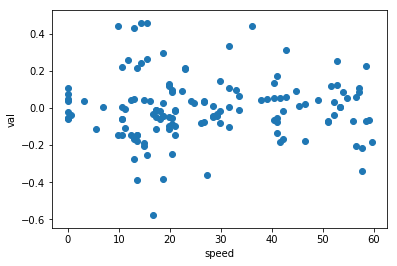

In [30]:
plt.scatter(res['speed'],res['no2_normal'])
plt.xlabel('speed')
plt.ylabel('val')
plt.show()

In [31]:
res[['lat','long','co','no2','pm10','pm25']].groupby(['lat','long']).mean()

,,co,no2,pm10,pm25
lat,long,,,,
40.665790,-73.757060,250.672857,34.139048,41.120476,16.432381
40.666420,-73.789580,247.312500,45.842500,55.180000,15.865000
40.673740,-73.801540,238.917500,34.765833,46.719167,15.570833
40.692360,-73.999390,254.403333,30.540000,49.853333,16.066667
40.700841,-73.815751,243.440000,45.843333,63.756667,19.543333
40.701580,-73.990330,337.406667,46.293333,62.796667,17.060000
40.708950,-73.996941,300.353333,25.615000,44.703333,17.316667
40.730165,-73.876430,284.695000,26.485000,51.447500,18.117500
40.737015,-73.853730,265.780000,33.270000,65.505000,20.605000


In [32]:
res.groupby(['lat','long']).get_group((40.76212,-74.9100000)).to_csv("group_40.665790_73.757060_normalized.csv",index = False)

In [33]:
one = res.groupby(['lat','long']).get_group((40.66579,-73.757060))
two = res.groupby(['lat','long']).get_group((40.74137,-74.008930))
three = res.groupby(['lat','long']).get_group((40.76212,-74.9100000))

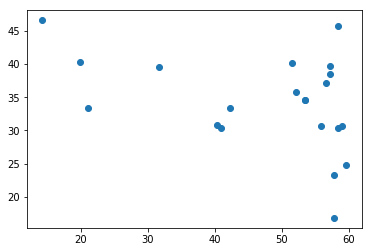

In [34]:
plt.scatter(one['speed'],one['no2'])
plt.show()

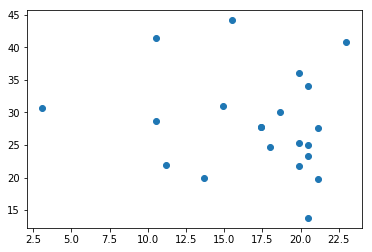

In [35]:
plt.scatter(two['speed'],two['no2'])
plt.show()

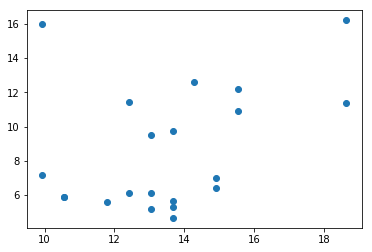

In [36]:
plt.scatter(three['speed'],three['pm25'])
plt.show()

In [37]:
ml = res

In [38]:
ml.head()

,new_date,lat,long,speed,datetime,co,no2,o3,pm10,pm25,so2,no2_normal,o3_normal,pm10_normal,pm25_normal,so2_normal,co_normal
0,2018-07-01T05:00:00,40.771900,-73.99401,0.00,2018-07-01T05:00:00,379.68,61.11,24.14,79.55,19.58,0.08,0.034990,-0.058173,0.069589,0.186567,-0.793651,0.007243
1,2018-07-01T05:00:00,40.760400,-74.00328,39.14,2018-07-01T05:00:00,403.08,66.22,24.74,67.38,21.38,0.08,0.047755,-0.057339,-0.124844,0.297619,-0.763359,0.006787
2,2018-07-01T05:00:00,40.701580,-73.99033,33.55,2018-07-01T05:00:00,412.11,66.61,26.70,79.33,20.09,0.07,0.063967,0.103810,0.064585,0.118400,-1.574803,0.017840
3,2018-07-01T05:00:00,40.730165,-73.87643,0.00,2018-07-01T05:00:00,367.80,44.23,29.70,64.86,24.42,0.07,0.105658,-0.042593,0.052108,0.211179,-1.549240,0.020652
4,2018-07-02T06:00:00,40.665790,-73.75706,31.68,2018-07-02T06:00:00,414.54,39.52,14.46,63.54,29.13,0.83,0.105083,-0.145399,0.089890,0.411272,7.326500,0.016909


In [39]:
ml.describe()

,lat,long,speed,co,no2,o3,pm10,pm25,so2,no2_normal,o3_normal,pm10_normal,pm25_normal,so2_normal,co_normal
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,1.370000e+02,1.370000e+02,1.370000e+02,1.370000e+02,1.370000e+02,1.370000e+02
mean,40.723545,-74.054501,27.240511,254.198029,29.017664,30.027591,41.586423,15.181314,0.314964,-2.552703e-17,-1.701802e-17,3.370175e-16,2.188031e-17,2.978963e-15,-9.370039e-19
std,0.039136,0.379355,16.842495,88.981334,15.041344,9.542777,18.801567,5.733888,0.419140,1.676051e-01,1.125301e-01,1.705132e-01,2.115421e-01,2.493074e+01,1.199001e-02
min,40.665790,-74.910000,0.000000,75.400000,0.590000,14.460000,4.360000,0.460000,0.000000,-5.777622e-01,-2.778338e-01,-1.265823e+00,-4.926108e-01,-1.155378e+02,-2.720328e-02
25%,40.673740,-74.010120,14.290000,208.640000,19.740000,22.530000,28.340000,11.430000,0.020000,-8.322078e-02,-6.524391e-02,-4.531320e-02,-1.501746e-01,-2.164889e+00,-7.963528e-03
50%,40.738950,-73.996941,21.120000,242.130000,30.420000,29.280000,41.250000,14.100000,0.050000,-1.265099e-02,-1.033748e-02,-2.025559e-03,-7.369078e-02,-1.309631e+00,-7.133358e-04
75%,40.756050,-73.793440,41.010000,302.210000,40.310000,33.610000,55.130000,19.590000,0.540000,7.451565e-02,5.783723e-02,3.976143e-02,1.191895e-01,2.060960e+00,6.744602e-03
max,40.793425,-73.740851,59.650000,457.260000,66.610000,71.290000,85.260000,29.130000,1.440000,4.584505e-01,3.045001e-01,1.265823e+00,5.889202e-01,1.354582e+02,3.302732e-02


## Predict speed

In [40]:
#split test train
x_col_speed = ['lat','long','co','no2','o3','pm10','pm25','so2','co_normal','no2_normal','o3_normal','pm10_normal','pm25_normal','so2_normal']
y_col_speed = ['speed']
X_train_speed,X_test_speed,y_train_speed,y_test_speed = train_test_split(ml[x_col_speed],ml[y_col_speed],test_size = 0.2,random_state = 5)

In [41]:
#model train
model = XGBRegressor()
model.fit(X_train_speed.values,y_train_speed.values)
y_pred_speed = model.predict(X_test_speed.values)

In [42]:
#pickle.dump(model, open("speed_model.dat", "wb"))
#pickle.dump(X_train_speed.columns, open("speed_model_features.dat", "wb"))

In [43]:
model.predict(X_test_speed.values)

array([14.605643 , 17.63864  , 52.317593 , 15.429791 , 21.362509 ,
       21.151976 , 11.437586 , 31.564312 ,  1.32757  , 43.566387 ,
        7.2633038, 19.420872 , 25.682774 , 24.220882 , 45.18686  ,
       49.729214 , 12.899038 ,  7.7721066, 34.29194  , 22.383467 ,
       15.570503 , 13.227825 , 48.778233 , 20.301592 , 14.60327  ,
       55.23297  , 31.391003 , 51.795776 ], dtype=float32)

In [44]:
accuracy_speed = mean_absolute_error(y_test_speed.values,y_pred_speed)
print(accuracy_speed)

10.086001697949003


In [45]:
rand_pred_speed =  np.random.uniform(low=min(y_test_speed.speed), high=max(y_test_speed.speed), size=(len(y_test_speed),))
rand_accuracy_speed = mean_absolute_error(y_test_speed.values,rand_pred_speed)
print(rand_accuracy_speed)

16.741043497875665


## Predict pollution

In [46]:
#split test train
x_col_poll = ['lat','long','speed']
var = 'pm25'
y_col_poll = ['pm25']
X_train_poll,X_test_poll,y_train_poll,y_test_poll = train_test_split(ml[x_col_poll],ml[y_col_poll],test_size = 0.2,random_state = 5)

In [47]:
#model train
model_poll = XGBRegressor()
model_poll.fit(X_train_poll.values,y_train_poll.values)
y_pred_poll = model_poll.predict(X_test_poll.values)

In [48]:
accuracy_poll = mean_absolute_error(y_test_poll.values,y_pred_poll)
print(accuracy_poll)

4.599268217086791


In [49]:
rand_pred_poll =  np.random.uniform(low=min(y_test_poll[var]), high=max(y_test_poll[var]), size=(len(y_test_poll),))
rand_accuracy_poll = mean_absolute_error(y_test_poll.values,rand_pred_poll)
print(rand_accuracy_poll)

5.655424459088086


In [50]:
pickle.dump(model, open("pollution_model.dat", "wb"))